In [9]:
import sys

sys.path.append("../")
import pandas as pd
from matplotlib import pyplot as plt

from processing.sanitization import get_sample_data
from processing.devices import BRYMEN_BM811_CURRENT, BRYMEN_BM811_VOLTAGE
from processing.linear_regression import get_regression, LinearRegressionData
from processing.uncertainty import compute_uncertainty
from generate_figures import get_zener_characteristics
from typing import Optional

In [10]:
from math import sqrt
from typing import List
import statsmodels.api as sm


def prepare_data(path: str, sort_ascending: Optional[bool] = True) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=False, header=0)
    df.sort_values(by="U", ascending=sort_ascending)

    df["u(U)"] = [compute_uncertainty(v, BRYMEN_BM811_VOLTAGE) for v in df["U"]]
    df["u(I)"] = [compute_uncertainty(i, BRYMEN_BM811_CURRENT) for i in df["I"]]

    return df


def merge_data(path_1: str, path_2: str) -> pd.DataFrame:
    df1 = prepare_data(path_1)
    df2 = prepare_data(path_2)
    df_result = pd.concat([df1, df2])

    df_result.sort_values(by="U", inplace=True)
    df_result.drop(df_result.tail(10).index, inplace=True)
    df_result.drop(df_result.head(10).index, inplace=True)

    df_result.to_csv("out.csv")

    return df_result


def plot_zener_with_regression(
    df: pd.DataFrame,
    forward_sample: int,
    reverse_sample: int,
    zener_voltage_index: int,
    zener_threshold_voltage_index: int,
) -> List[LinearRegressionData]:
    forward_regr_voltage = df["U"][-reverse_sample:].to_numpy()
    forward_regr_current = df["I"][-reverse_sample:].to_numpy()

    reverse_regr_voltage = df["U"][:forward_sample].to_numpy()
    reverse_regr_current = df["I"][:forward_sample].to_numpy()

    forward_data, forward_vals, forward_model = get_regression(
        forward_regr_voltage, forward_regr_current
    )
    reverse_data, reverse_vals, reverse_model = get_regression(
        reverse_regr_voltage, reverse_regr_current
    )

    plt.figure()
    plt.grid()
    plt.xlabel("U[mV]")
    plt.ylabel("I[mA]")
    plt.errorbar(
        df["U"], df["I"], xerr=df["u(U)"], yerr=df["u(I)"], zorder=-1, ls="None"
    )
    plt.scatter(df["U"], df["I"], zorder=-1, ls="None", s=2)

    plt.plot(forward_vals, forward_model.predict(forward_vals), color="red")
    plt.plot(reverse_vals, reverse_model.predict(reverse_vals), color="orange")

    plt.scatter(
        df["U"][zener_voltage_index],
        df["I"][zener_voltage_index],
        zorder=3,
        ls="None",
        s=40,
        color="black",
        label="U_z",
    )
    plt.scatter(
        df["U"][zener_threshold_voltage_index],
        df["I"][zener_threshold_voltage_index],
        zorder=3,
        ls="None",
        s=40,
        color="green",
        label="U_zk",
    )

    plt.legend(loc="upper left")

    return [forward_data, reverse_data]


def plot_with_regression(df: pd.DataFrame) -> LinearRegressionData:
    regr_voltage = df["U"][-30:].to_numpy()
    regr_current = df["I"][-30:].to_numpy()

    x = sm.add_constant(regr_voltage)
    model = sm.OLS(regr_current, x)
    results = model.fit()
    print(results.summary())

    data, vals, model = get_regression(regr_voltage, regr_current)

    plt.figure()
    plt.grid()
    plt.xlabel("U[mV]")
    plt.ylabel("I[mA]")

    plt.errorbar(
        df["U"], df["I"], xerr=df["u(U)"], yerr=df["u(I)"], zorder=-1, ls="None"
    )
    plt.scatter(df["U"], df["I"], zorder=-1, ls="None", s=2)

    plt.plot(vals, model.predict(vals), color="orange")
    plt.plot(vals, model.predict(vals), color="orange")

    plt.show()

    return data


def sample_data_presentation(df_1: pd.DataFrame, df_2: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df_1[0:40], df_2[0:40]], axis=1)


def styled_latex_output(df: pd.DataFrame) -> str:
    latex = df.to_latex(index=False, header=True, escape=False)

    # Define header styling
    header = r"\rowcolor{lightgray}"

    # Add header styling to first row of LaTeX output
    latex = latex.split("\n")
    latex[0] = header + latex[0]
    latex = "\n".join(latex)

    # Add multirow and booktabs packages to LaTeX output preamble
    preamble = r"""
    \usepackage{multirow}
    \usepackage{booktabs}
    \usepackage[table]{xcolor}
    \definecolor{lightgray}{gray}{0.9}
    \setlength{\aboverulesep}{0pt}
    \setlength{\belowrulesep}{0pt}
    \setlength{\extrarowheight}{1pt}
    """
    latex = latex.replace(
        "\\begin{tabular}", "\\begin{tabular}{>{\\rule{0pt}{2.5ex}}ll}"
    )

    # Add colortbl package to LaTeX output and define table border
    latex = latex.replace("\\begin{tabular}{", "\\begin{tabular}{|l|l|}")
    latex = (
        "\\begin{tabular}{|l|l|}\n\\hline\n" + latex.split("\\begin{tabular}{|l|l|}")[1]
    )
    latex = latex.split("\\end{tabular}")[0] + "\\hline\n\\end{tabular}"

    # Combine preamble and table
    return preamble + "\n" + latex


def misc_data(uz, iz):
    rs = uz / iz

    u_uz = compute_uncertainty(uz, BRYMEN_BM811_VOLTAGE)
    u_iz = compute_uncertainty(iz, BRYMEN_BM811_CURRENT)
    u_rs = sqrt(((u_uz / iz) ** 2 + (uz * u_iz) / (iz**2)) ** 2)

    print("zener voltage: ", uz, compute_uncertainty(uz, BRYMEN_BM811_VOLTAGE))
    print("zener current: ", iz, compute_uncertainty(iz, BRYMEN_BM811_CURRENT))
    print("static resistance: ", rs, u_rs)

# Rectifying

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     777.5
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           5.71e-22
Time:                        21:27:46   Log-Likelihood:                -30.333
No. Observations:                  30   AIC:                             64.67
Df Residuals:                      28   BIC:                             67.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1744.7253     65.890    -26.479      0.0

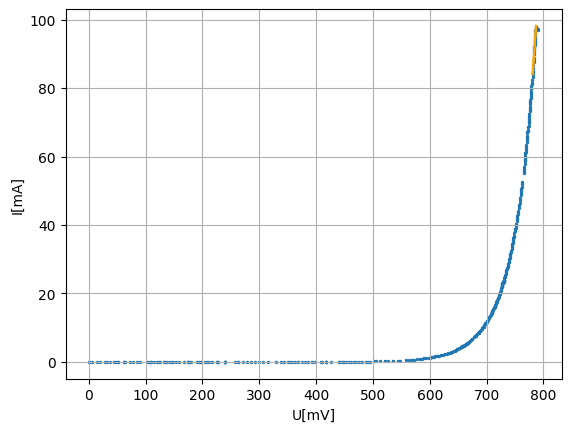

a=2.341667016347249 b=-1744.7252745628357
a:  1.8351363885885021 0.021524123647185187
b:  -1348.6378340617748 16.687298396305987
breakthrough voltage:  734.8978759551935
breakthrough voltage uncertainty (12.52929073625558+0j)
dynamic resistance:  0.544918626331175 0.006391293837199648
min voltage:  1506 1.6763942416189974
min current:  1.02 0.000348719562590534
zener voltage:  -2501 0.5780430895126533
zener current:  -38.22 0.004182325350009649
static resistance:  65.43694400837258 (0.00693187358587494+0j)


/Users/igorkrzywda/opt/anaconda3/envs/data/lib/python3.11/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 2 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


In [11]:
from sigfig import round
from tabulate import tabulate


data = prepare_data("data/multimeter_data/sanitized/rectifying.csv")
data.reset_index(inplace=True, drop=True)
sample = get_sample_data(data, 40)

linear_regression_coeffs = plot_with_regression(data)

print(linear_regression_coeffs)
rounded = sample.applymap(lambda x: round(x, sigfigs=2))


forward_regr_voltage = data["U"][-100:].to_numpy()
forward_regr_current = data["I"][-100:].to_numpy()

get_zener_characteristics(
    forward_regr_voltage, forward_regr_current, 1506, 1.02, -2501, -38.22
)

# Zener diode 2

a:  1.9428692555769966 0.017508834075213007
b:  -1544.9816677874564 14.532282920087857
breakthrough voltage:  795.2061948340549
breakthrough voltage uncertainty (10.358714356671316+0j)
dynamic resistance:  0.5147026734452177 0.004638420048879978
min voltage:  1506 1.6763942416189974
min current:  1.02 0.000348719562590534
zener voltage:  -2501 0.5780430895126533
zener current:  -38.22 0.004182325350009649
static resistance:  65.43694400837258 (0.00693187358587494+0j)


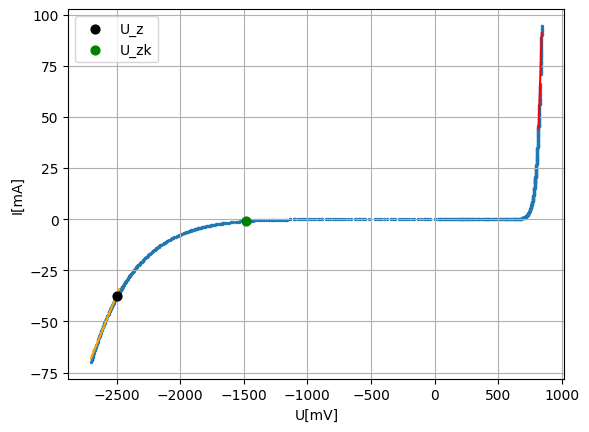

In [12]:
forward = prepare_data("data/multimeter_data/sanitized/zener-p-2.csv")
reverse = prepare_data("data/multimeter_data/sanitized/zener-z-2.csv")

sample = sample_data_presentation(forward, reverse)

data = merge_data(
    "data/multimeter_data/sanitized/zener-p-2.csv",
    "data/multimeter_data/sanitized/zener-z-2.csv",
)

data.reset_index(inplace=True, drop=True)

data.to_csv("data/multimeter_data/merged/zener-2.csv")

sample = get_sample_data(data, 40)


linear_regression_coeffs = plot_zener_with_regression(data, 100, 100, 93, 270)


forward_regr_voltage = data["U"][-100:].to_numpy()
forward_regr_current = data["I"][-100:].to_numpy()

get_zener_characteristics(
    forward_regr_voltage, forward_regr_current, 1506, 1.02, -2501, -38.22
)

[LinearRegressionData(a=1.71506251249461, b=-1356.8784539767948), LinearRegressionData(a=0.12740820987426146, b=360.08489983782937)]
a:  1.7150625124946166 0.01631552103008123
b:  -1356.8784539768003 13.508428123969566
breakthrough voltage:  791.1539340937343
breakthrough voltage uncertainty (10.894134184101341+0j)
dynamic resistance:  0.5830691258859516 0.005546781249125566
min voltage:  1933 1.8243113805853794
min current:  1.02 0.000348719562590534
zener voltage:  -3001 0.9244532510264285
zener current:  -28.11 0.003014923105708226
static resistance:  106.75916044112415 (0.010368842973444713+0j)


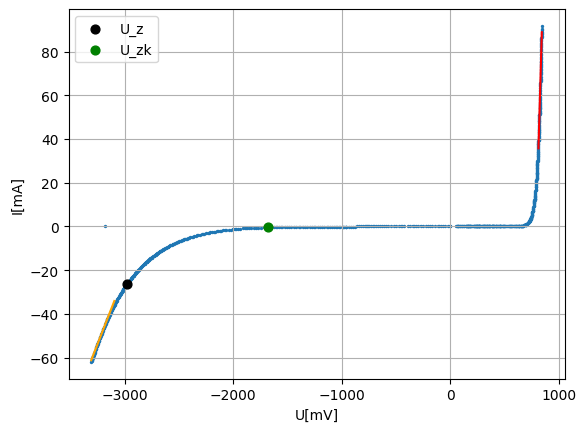

In [13]:
forward = prepare_data("data/multimeter_data/sanitized/zener-p-3.csv")
reverse = prepare_data("data/multimeter_data/sanitized/zener-z-3.csv")

sample = sample_data_presentation(forward, reverse)

data = merge_data(
    "data/multimeter_data/sanitized/zener-p-3.csv",
    "data/multimeter_data/sanitized/zener-z-3.csv",
)
data.reset_index(inplace=True, drop=True)
data.to_csv("data/multimeter_data/merged/zener-3.csv")
sample = get_sample_data(data, 40)


linear_regression_coeffs = plot_zener_with_regression(data, 100, 100, 142, 317)
print(linear_regression_coeffs)
forward_regr_voltage = data["U"][-100:].to_numpy()
forward_regr_current = data["I"][-100:].to_numpy()

get_zener_characteristics(
    forward_regr_voltage, forward_regr_current, 1933, 1.02, -3001, -28.11
)

[LinearRegressionData(a=1.919456518505407, b=-1553.2209202934077), LinearRegressionData(a=0.1017760601574804, b=395.3644114296914)]
a:  1.9194565185054084 0.014918717559793574
b:  -1553.2209202934089 12.635120781463755
breakthrough voltage:  809.198283638553
breakthrough voltage uncertainty (9.104268942774041+0j)
dynamic resistance:  0.5209808038676769 0.0040492532089385705
min voltage:  2805 2.126381041425392
min current:  1.05 0.0003521836642056718
zener voltage:  -4007 1.621430495992145
zener current:  -18.66 0.001923731096939833
static resistance:  214.7374062165059 (0.014587644565596396+0j)


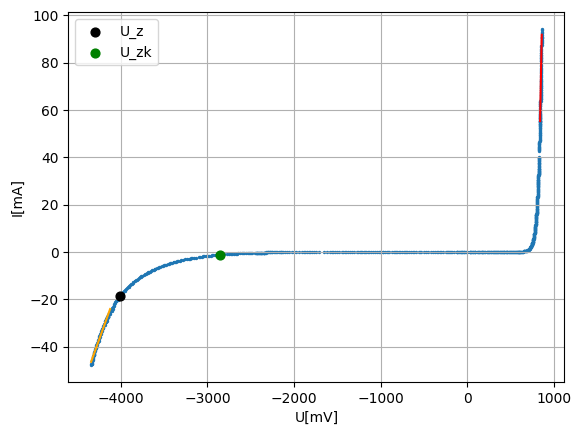

In [14]:
forward = prepare_data("data/multimeter_data/sanitized/zener-p-4.csv")
reverse = prepare_data("data/multimeter_data/sanitized/zener-z-4.csv")

sample = sample_data_presentation(forward, reverse)

data = merge_data(
    "data/multimeter_data/sanitized/zener-p-4.csv",
    "data/multimeter_data/sanitized/zener-z-4.csv",
)


data.reset_index(inplace=True, drop=True)
data.to_csv("data/multimeter_data/merged/zener-4.csv")
sample = get_sample_data(data, 40)


linear_regression_coeffs = plot_zener_with_regression(data, 100, 100, 120, 207)
print(linear_regression_coeffs)
forward_regr_voltage = data["U"][-100:].to_numpy()
forward_regr_current = data["I"][-100:].to_numpy()

get_zener_characteristics(
    forward_regr_voltage, forward_regr_current, 2805, 1.05, -4007, -18.66
)

In [15]:
compute_uncertainty(2501, BRYMEN_BM811_VOLTAGE)
# compute_uncertainty(64, BRYMEN_BM811_CURRENT)

2.021072352325204